In [1]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf

# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10 
test_set_size_percentage = 10 

In [2]:
# import all stock prices 
df = pd.read_csv("T.csv", index_col = 0)
df = df.drop(columns=['Adj Close'])
df['symbol'] = 'T'
df = df.rename({'Open': 'open', 'High': 'high','Low': 'low', 'Close': 'close','Volume': 'volume'}, axis=1)

df.info()
df.head()

# number of different stocks
print('\nnumber of different stocks: ', len(list(set(df.symbol))))
print(list(set(df.symbol))[:10])

<class 'pandas.core.frame.DataFrame'>
Index: 1258 entries, 2016-10-07 to 2021-10-06
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    1258 non-null   float64
 1   high    1258 non-null   float64
 2   low     1258 non-null   float64
 3   close   1258 non-null   float64
 4   volume  1258 non-null   int64  
 5   symbol  1258 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 68.8+ KB

number of different stocks:  1
['T']


In [3]:
df.head()

,open,high,low,close,volume,symbol
Date,,,,,,
2016-10-07,39.220001,39.290001,38.709999,38.869999,19172000,T
2016-10-10,38.930000,39.200001,38.209999,39.009998,19020700,T
2016-10-11,38.939999,39.380001,38.599998,39.099998,22314900,T
2016-10-12,39.150002,39.490002,39.060001,39.330002,17179900,T
2016-10-13,39.279999,39.480000,39.020000,39.369999,17546600,T


In [4]:
df.tail()

,open,high,low,close,volume,symbol
Date,,,,,,
2021-09-30,27.480000,27.510000,27.010000,27.010000,44338700,T
2021-10-01,27.139999,27.400000,27.010000,27.160000,31540400,T
2021-10-04,27.240000,27.459999,27.090000,27.250000,43725400,T
2021-10-05,27.299999,27.480000,27.170000,27.350000,32212500,T
2021-10-06,27.260000,27.334999,26.969999,27.309999,54858810,T


In [5]:
df.describe()

,open,high,low,close,volume
count,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03
mean,33.665294,33.926729,33.386081,33.652806,3.368055e+07
std,4.260876,4.262203,4.263670,4.273215,1.795166e+07
min,26.500000,26.879999,26.080000,26.500000,8.697200e+06
25%,29.962499,30.170000,29.680000,29.910000,2.320540e+07
50%,32.535000,32.790001,32.225001,32.504999,2.995135e+07
75%,37.627501,37.919998,37.325002,37.580002,3.903052e+07
max,42.939999,43.029999,42.709999,43.020000,2.470524e+08


In [6]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1258 entries, 2016-10-07 to 2021-10-06
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    1258 non-null   float64
 1   high    1258 non-null   float64
 2   low     1258 non-null   float64
 3   close   1258 non-null   float64
 4   volume  1258 non-null   int64  
 5   symbol  1258 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 68.8+ KB


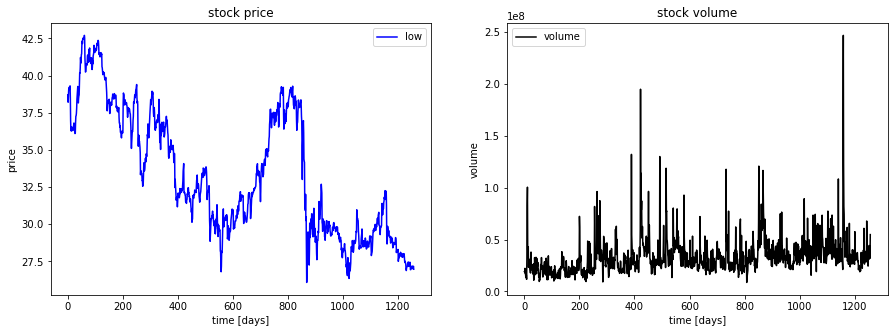

In [7]:
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);
plt.plot(df[df.symbol == 'T'].low.values, color='blue', label='low')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()

plt.subplot(1,2,2);
plt.plot(df[df.symbol == 'T'].volume.values, color='black', label='volume')
plt.title('stock volume')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best');

In [8]:
# function for min-max normalization of stock
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))
    return df

# function to create train, validation, test data given stock data and sequence length
def load_data(stock, seq_len):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

# choose one stock
df_stock = df[df.symbol == 'T'].copy()
df_stock.drop(['symbol'],1,inplace=True)
df_stock.drop(['volume'],1,inplace=True)

cols = list(df_stock.columns.values)
print('df_stock.columns.values = ', cols)

# normalize stock
df_stock_norm = df_stock.copy()
df_stock_norm = normalize_data(df_stock_norm)

# create train, test data
seq_len = 20 # choose sequence length
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

df_stock.columns.values =  ['open', 'high', 'low', 'close']
x_train.shape =  (990, 19, 4)
y_train.shape =  (990, 4)
x_valid.shape =  (124, 19, 4)
y_valid.shape =  (124, 4)
x_test.shape =  (124, 19, 4)
y_test.shape =  (124, 4)


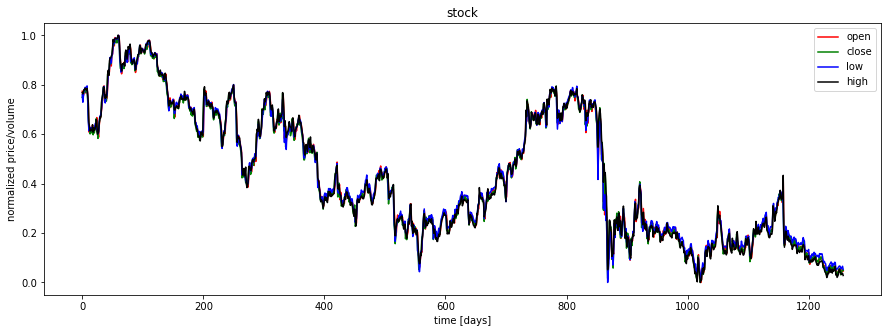

In [9]:
plt.figure(figsize=(15, 5));
plt.plot(df_stock_norm.open.values, color='red', label='open')
plt.plot(df_stock_norm.close.values, color='green', label='close')
plt.plot(df_stock_norm.low.values, color='blue', label='low')
plt.plot(df_stock_norm.high.values, color='black', label='high')
#plt.plot(df_stock_norm.volume.values, color='gray', label='volume')
plt.title('stock')
plt.xlabel('time [days]')
plt.ylabel('normalized price/volume')
plt.legend(loc='best')
plt.show()

In [42]:
## Basic Cell RNN in tensorflow

index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

# parameters
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = 200 
n_outputs = 4
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.compat.v1.reset_default_graph()

# X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
# y = tf.placeholder(tf.float32, [None, n_outputs])

X = tf.disable_v2_behavior()
y = tf.disable_v2_behavior()

# use Basic RNN Cell
layers = [tf.compat.v1.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
          for layer in range(n_layers)]

# use Basic LSTM Cell 
#layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
#          for layer in range(n_layers)]

# use LSTM Cell with peephole connections
#layers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons, 
#                                  activation=tf.nn.leaky_relu, use_peepholes = True)
#          for layer in range(n_layers)]

# use GRU cell
#layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
#          for layer in range(n_layers)]
                                                                     
multi_layer_cell = tf.keras.layers.StackedRNNCells(layers)
rnn_outputs, states = tf.compat.v1.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run graph
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    

ValueError: None values not supported.